# **CIS 4190/5190 Homework 4 - Spring 2024**

**Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. This is the master notebook so <u>you will not be able to save your changes without copying it </u>! Once you click on that, make sure you are working on that version of the notebook so that your work is saved**

In [192]:
# Restart the runtime after running this cell everytime you open the notebook
#!pip install pandas==1.1.5
!pip install --upgrade gdown

In [193]:
!pip install dill

In [194]:
import random
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
from scipy.spatial import distance
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
np.random.seed(42)  # don't change this line

import base64
import datetime

# **PennGrader Setup**
First, you'll need to set up the PennGrader, an autograder we are going to use throughout the semester. The PennGrader will automatically grade your answer and provide you with an instant feedback. Unless otherwise stated, you can resubmit up to a reasonable number of attempts (e.g. 100 attemptes per day). **We will only record your latest score in our backend database**.

After finishing each homework assignment, you must submit your iPython notebook to gradescope before the homework deadline. Gradescope will then retrive and display your scores from our backend database.

In [195]:
%%capture
!pip3 install penngrader --upgrade

In [196]:
from penngrader.grader import *

In [197]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID =  29869722         # YOUR PENN-ID GOES HERE AS AN INTEGER#

Run the following cell to initialize the autograder. This autograder will let you submit your code directly from this notebook and immediately get a score.

**NOTE:** Remember we store your submissions and check against other student's submissions... so, not that you would, but no cheating.

In [198]:
grader = PennGrader(homework_id = 'cis5190_sp24_HW4', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 29869722

Make sure this correct or we will not be able to store your grade


In [199]:
# Serialization code needed by the autograder
import inspect, sys
from IPython.core.magics.code import extract_symbols

def new_getfile(object, _old_getfile=inspect.getfile):
    if not inspect.isclass(object):
        return _old_getfile(object)

    # Lookup by parent module (as in current inspect)
    if hasattr(object, '__module__'):
        object_ = sys.modules.get(object.__module__)
        if hasattr(object_, '__file__'):
            return object_.__file__

    # If parent module is __main__, lookup by methods (NEW)
    for name, member in inspect.getmembers(object):
        if inspect.isfunction(member) and object.__qualname__ + '.' + member.__name__ == member.__qualname__:
            return inspect.getfile(member)
    else:
        raise TypeError('Source for {!r} not found'.format(object))
inspect.getfile = new_getfile

def grader_serialize(obj):
    cell_code = "".join(inspect.linecache.getlines(new_getfile(obj)))
    class_code = extract_symbols(cell_code, obj.__name__)[0][0]
    return class_code

if not os.path.exists("cis519_hw1_diabetes_train.csv"):
    !curl "https://drive.usercontent.google.com/download?id=1wfZ375m-HOvtWb8fBUjZ2zbW5nkXtlVx&confirm=xxx" > cis519_hw1_diabetes_train.csv
    !curl "https://drive.usercontent.google.com/download?id=14DGsr_eIHRGnDw4o7FVBFUVfg_MljzzO&confirm=xxx" > cis519_hw1_diabetes_X_test.csv

In [200]:

import gdown
if not os.path.exists("observations.csv"):
  !gdown --id 1RvNTrL147Cx90ABv4IfXcexaRyHB-U-e
if not os.path.exists("test_student.csv"):
  !gdown --id 1Z0I6iylDgTk2OKuKDaQVR9I1aJvgRsn_

#### **NOTE 1. If you are running into a `__builtins__' error, it's likely because you're using a function call of the form numpy.ndarray.mean(), like a.mean(). This does not play nice with PennGrader unfortunately. Please use the function call numpy.mean(a) instead.**

In [201]:
def prepare_final_cleaned_df(df):
  df = df.drop(["Unnamed: 0"], axis=1)
  df["mdct"] = pd.to_datetime(df["mdct"])
  df.loc[df["gust"].isna(),"gust"] = 0
  df.loc[df["gbrd"].isna(),"gbrd"] = 0
  df.loc[df["wdsp"].isna(),"wdsp"] = 0
  df.loc[df["dewp"].isna(),"dewp"] = 0
  df.loc[df["dmin"].isna(),"dmin"] = 0
  df.loc[df["dmax"].isna(),"dmax"] = 0
  df = df[df["temp"] != 0]
  df = df.drop(columns=["prcp"])

  left_df = df.copy()
  right_df = df.copy()
  right_df["mdct"] = right_df["mdct"].apply(lambda x : x + datetime.timedelta(hours=1))

  columns = ["stp", "smax", "smin", "gbrd", "dewp", "tmax",
            "dmax", "tmin", "dmin", "hmdy", "hmax",
            "hmin", "wdsp", "wdct", "gust", "temp"]

  merged_df = pd.merge(left_df, right_df, "left", on=["wsid","mdct"], indicator=True)
  merged_df = merged_df[merged_df['_merge'] == "both"]

  columns_x = [x + "_x" for x in columns]
  columns_y = [x + "_y" for x in columns]

  merged_df[columns] = merged_df[columns_x].values - merged_df[columns_y].values
  merged_df = merged_df.drop(columns=columns_x)
  merged_df = merged_df.drop(columns=columns_y)
  merged_df = merged_df.drop(columns=["_merge", "mdct", "wsid"])

  final_cleaned_df = merged_df.copy()

  final_cleaned_df.loc[final_cleaned_df["temp"] >= 0, "temp" ] = 1
  final_cleaned_df.loc[final_cleaned_df["temp"] < 0, "temp" ] = 0
  return final_cleaned_df

# **1. [25 pts, autograded] AdaBoost**

## **1.1.  [3 pts] Logistic regression with sample weights**

As you will have learnt from the lectures, AdaBoost fits weak learners (here, logistic regression model)  in each iteration, to a dataset with weights $w_i$ attached to each sample $(x_i, y_i)$. The loss function now becomes:

> $
\mathcal{L}({\theta}) = -\sum_{i =1}^N w_{i} \times [ y_i\log(h_{{\theta}}({x}_i)) + (1 - y_i)\log(1 - h_{{\theta}}({x}_i))]
$

where $h_\theta(x)$ is the logistic regression hypothesis function.

The gradient of this weighted loss function with respect to the weight $\theta_j$ is given by:

> $\frac{\partial \mathcal{L}({\theta})}{\partial \theta_j} = \sum_{i=1}^{N}w_{i}(h_{{\theta}}({x}_i) - y_i)x_{ij}$

Using this information, complete the `compute_gradient` method in the `LogisticRegression` class to account for sample weights.

In [202]:
class LogisticRegression:
    """
    Logistic Regression (aka logit, MaxEnt) classifier.

    Parameters
    ----------
    alpha: float, default=0.1
        Learning rate
    tol : float, default=0.01
        Tolerance for stopping criteria
    max_iter : int, default=1000
        Maximum number of iterations of gradient descent

    Attributes
    ----------
    theta_ : numpy.ndarray of shape (D + 1,)
        The value of the coefficients after gradient descent has converged
        or the number of iterations hit the maximum limit
    converged_: boolean
        Boolean value indicating whether gradient descent converged or not
    """

    def __init__(self, alpha=0.1, tol=0.01, max_iter=1000):

        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter

        self.theta_ = None
        self.converged_ = False

    def compute_gradient(self, theta, X, y, sample_weight):
        """
        Compute the gradient of the cost function.

        Parameters
        ----------
        theta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array
        sample_weight: numpy.ndarray of shape (N,)
            The sample weight array

        Returns
        -------
        gradient: numpy.ndarray of shape (D + 1,)
            The gradient values
        """

        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        y_hat = sigmoid(X.dot(theta))

        # STUDENT TODO: Compute the gradient
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        y_hat = sigmoid(X.dot(theta))
        gradient = np.dot(X.T, (y_hat - y) * sample_weight)

        return gradient
        # STUDENT TODO END

    def fit(self, X, y, sample_weight):
        """
        Compute the coefficients using gradient descent and store them as theta_.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array
        sample_weight: numpy.ndarray of shape (N,)
            The sample weight array

        Returns
        -------
        Nothing
        """

        N, D = X.shape

        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))

        theta_old = np.zeros((D + 1,))
        theta_new = theta_old.copy()

        for i in range(self.max_iter):
            theta_new = theta_old - self.alpha * self.compute_gradient(theta_old, X, y, sample_weight)

            if np.linalg.norm(theta_new - theta_old) / (np.linalg.norm(theta_old) + self.tol) <= self.tol:
                self.converged_ = True
                break

            theta_old = theta_new.copy()

        self.theta_ = theta_new

    def predict_proba(self, X):
        """
        Predict the probabilities that the data points in X belong to class 1.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix

        Returns
        -------
        y_hat: numpy.ndarray of shape (N,)
            The predicted probabilities that the data points in X belong to class 1
        """

        N = X.shape[0]

        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))

        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        y_hat = sigmoid(X.dot(self.theta_))
        return y_hat

    def predict(self, X):
        """
        Predict the classes of the data points in X.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix

        Returns
        -------
        y_pred: numpy.ndarray of shape (N,)
            The predicted class of the data points in X
        """

        y_hat = self.predict_proba(X)
        y_pred = y_hat.copy()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        return y_pred

### Test case for the `compute_gradient` method

In [203]:
def test_compute_gradient(StudentLogisticRegression):

    student_lr_clf = StudentLogisticRegression()
    np.random.seed(0)
    theta_tc = np.random.randn(2)
    X_tc = np.random.randn(100, 2)
    y_tc = np.random.randint(0, 2, 100)
    sample_weight_tc = np.random.uniform(0, 1, 100)
    student_ans = student_lr_clf.compute_gradient(theta_tc, X_tc, y_tc, sample_weight_tc)
    required_ans = np.array([12.903225675830651, -1.0829605960182223])

    assert np.linalg.norm(student_ans - required_ans) < 1e-2 * required_ans.size

test_compute_gradient(LogisticRegression)

In [204]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_compute_gradient_autograder', answer = grader_serialize(LogisticRegression))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.2. [20 pts] AdaBoostClassifier Implementation**

In this section, you will be implementing the AdaBoost classifier with the logistic regression weak learner from above.

### **1.2.1. [12 pts] Follow the hints in the `fit` method in the `AdaBoostClassifier` class to implement the following algorithm.**

Use the following Adaboost pseudocode as a reference.

**INPUT:**

1. training data $X, y = \{(x_{i}, y_{i})\}_{i=1}^N$

2. number of iterations $T$

**ALGORITHM:**

1.   Initialize $N$ uniform weights, i.e., $w_{1} = [1/N, 1/N, ..., 1/N]$

2.   `For` $t = 1, 2, ... T$:

> 2.1. Train model $h_t$ on $X$ and $y$ with instance weights $w_{t}$

> 2.2. Compute the weighted training error rate of $h_{t}$: $\epsilon_{t} = \sum_{i: y_i \ne h_t(x_i)} w_{t,i}$

> 2.3. If $\epsilon_{t} > 0.5$, flip $h_t$'s predictions

> 2.4. Set $\beta_{t} = \frac{1}{2}\text{ln}\left(\frac{1 - \epsilon_t}{\epsilon_t}\right)$

> 2.5. Update all instance weights: $w_{t + 1,i} = w_{t,i}\times\text{exp}(-\beta_{t}y_{i}h_{t}(x_{i}))$ $\forall i = 1, 2, ..., N$

> 2.6. Normalize $w_{t+1}$ such that the elements sum to 1

> `End For`

### **1.2.2. [8 pts] Follow the hints in the `predict` method in the `AdaBoostClassifier` class for obtaining the predictions of the trained AdaBoost classifier.**

> $H(x) = \text{sign}\left(\sum_{t=1}^{T}\beta_{t}h_{t}(x)\right)$

In [205]:
class AdaBoostClassifier:
    """
    AdaBoost classifier based on logistic regression

    Parameters
    ----------
    T: int, default=100
        The number of logistic regression models in the boosting model

    Attributes
    ----------
    beta_arr_ : list of length T
        The list of beta values in the boosting model

    h_arr_: list of length T
        The list of logistic regression models in the boosting model
    """

    def __init__(self, T=100):

        self.T = T

        self.beta_arr_ = []
        self.h_arr_ = []

    def fit(self, X, y):
        """
        Train the logistic regression models (h) and compute their coefficients (beta),
        and store them in h_arr_ and beta_arr_ respectively.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        Nothing
        """

        # N = X.shape[0]
        N = X.shape[0]
        w = np.array([1/N] * N)
        y_ = y.copy()

        y_ [y == 0] = -1

        for t in range(self.T):
            h = LogisticRegression()
            h.fit(X, y, sample_weight=w)  #

            y_pred = h.predict(X)
            # y_pred_ = np.where(y_pred == 0, -1, 1)
            errors = (y_pred != y)
            epsilon = np.sum(w * errors)

            if epsilon > 0.5:
                y_pred = 1 - y_pred
                h.theta_[0] = -h.theta_[0]
                errors = (y_pred != y)
                epsilon = np.sum(w * errors)

            self.h_arr_.append(h)

            if epsilon == 0:
                beta = np.inf
                self.beta_arr_.append(beta)
                break

            beta = 0.5 * np.log((1 - epsilon) / epsilon)
            self.beta_arr_.append(beta)
            y_pred_ = y_pred.copy()
            y_pred_[y_pred == 0] = -1
            w *= np.exp(-beta * y_ * y_pred_)
            w /= np.sum(w)





    def predict(self, X):

        N = X.shape[0]

        sum_beta_times_h = np.zeros((N,))

        for t in range(len(self.h_arr_)):

          ht = self.h_arr_[t]
          y_pred = ht.predict(X)

          y_pred [y_pred == 0] = -1
          sum_beta_times_h += self.beta_arr_[t] * y_pred
        yy = np.where(sum_beta_times_h >= 0, 1, 0)

        return yy



          # STUDENT TODO END


### Test case for the `fit` method

In [206]:
def test_adaboost_fit(StudentAdaBoostClassifier):

    T = 4
    N = 100
    D = 2

    student_ab_clf = StudentAdaBoostClassifier(T=T)
    np.random.seed(0)
    X_tc = np.random.randn(N, D)
    y_tc = np.random.randint(0, 2, N)
    student_ab_clf.fit(X_tc, y_tc)

    beta_arr_student_ans = student_ab_clf.beta_arr_
    beta_arr_required_ans = np.array([0.08017132503758954, 0.046732864002838985,
                                      0.022808008179707476, 0.07012335626140642])
    print(beta_arr_student_ans)
    assert np.linalg.norm(beta_arr_student_ans - beta_arr_required_ans) < 1e-2 * beta_arr_required_ans.size

    h_arr_student_ans = np.zeros([T, D + 1])

    for indx, h in enumerate(student_ab_clf.h_arr_):
        h_arr_student_ans[indx] = h.theta_

    h_arr_required_ans = np.array([[-0.01514967, -0.01713051,  0.21344566],
                                   [-0.01738886, -0.00656722,  0.12035635],
                                   [-0.0132557,  -0.00428943, 0.06616284],
                                   [-0.01037174, -0.00334141,  0.03943088]])

    assert np.linalg.norm(h_arr_student_ans - h_arr_required_ans) < 1e-2 * h_arr_required_ans.size

test_adaboost_fit(AdaBoostClassifier)

[0.08017132503758954, 0.046732864002838985, 0.022808008179707476, 0.07012335626140642]


In [207]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_adaboost_fit_autograder', answer = (grader_serialize(LogisticRegression), grader_serialize(AdaBoostClassifier)))

Correct! You earned 12/12 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### Test case for the `predict` method

In [208]:
def test_adaboost_predict(StudentAdaBoostClassifier):

    T = 4
    N = 100
    D = 2

    student_ab_clf = StudentAdaBoostClassifier(T=T)
    np.random.seed(0)
    X_tc = np.random.randn(N, D)
    y_tc = np.random.randint(0, 2, N)
    student_ab_clf.fit(X_tc, y_tc)

    student_ans = student_ab_clf.predict(X_tc)
    required_ans = [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                    0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
                    1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
                    0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
                    1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]

    assert np.mean(student_ans == required_ans) >= 0.98

test_adaboost_predict(AdaBoostClassifier)

In [209]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_adaboost_predict_autograder', answer = (grader_serialize(LogisticRegression), grader_serialize(AdaBoostClassifier)))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.3. [2 pts] AdaBoost on the dataset**

Follow the hints in the `adaboost_on_dataset` method in the below cell to run `AdaBoostClassifier` on the dataset.

In [210]:
# Load Dataset
df = pd.read_csv("observations.csv")
final_cleaned_df = prepare_final_cleaned_df(df)

In [211]:
df

,Unnamed: 0,wsid,mdct,prcp,stp,smax,smin,gbrd,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,0,178,2007-11-06 00:00:00,NaN,982.5,982.5,981.3,NaN,29.3,12.1,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
1,1,178,2007-11-06 01:00:00,NaN,983.2,983.2,982.5,NaN,29.0,13.5,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2,2,178,2007-11-06 02:00:00,NaN,983.5,983.5,983.2,NaN,27.4,14.0,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
3,3,178,2007-11-06 03:00:00,NaN,983.7,983.7,983.4,NaN,25.8,16.9,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
4,4,178,2007-11-06 04:00:00,NaN,983.7,983.8,983.6,NaN,25.4,16.4,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,121995,423,2011-05-09 11:00:00,NaN,929.1,929.1,928.6,229.705,16.2,14.6,16.2,14.9,14.3,13.4,90.0,94.0,90.0,0.7,244.0,2.4
121996,121996,423,2011-05-09 12:00:00,NaN,929.7,929.9,929.1,565.674,18.0,15.8,18.0,15.8,15.8,14.4,87.0,93.0,87.0,0.9,198.0,2.8
121997,121997,423,2011-05-09 13:00:00,NaN,929.6,929.7,929.5,1578.380,20.6,16.0,21.2,16.9,18.0,15.3,75.0,87.0,72.0,2.2,149.0,5.7
121998,121998,423,2011-05-09 14:00:00,NaN,929.4,929.8,929.4,1113.874,21.2,16.5,21.2,16.7,20.1,15.9,75.0,79.0,74.0,2.9,181.0,7.1


In [212]:
final_cleaned_df

,stp,smax,smin,gbrd,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,temp
1,0.7,0.7,1.2,0.000,1.4,0.2,-3.2,3.5,1.4,4.0,-19.0,3.0,0.4,-7.0,-0.1,0.0
2,0.3,0.3,0.7,0.000,0.5,-0.9,0.4,-1.6,1.4,5.0,5.0,4.0,-1.1,-1.0,0.5,0.0
3,0.2,0.2,0.2,0.000,2.9,-1.6,2.9,-1.6,0.5,14.0,14.0,5.0,-0.8,3.0,-1.1,0.0
4,0.0,0.1,0.2,0.000,-0.5,-1.1,0.1,-0.5,2.3,-1.0,0.0,12.0,1.4,14.0,1.7,0.0
5,0.0,0.0,0.0,0.000,-0.2,-0.9,-0.6,-1.5,-0.4,5.0,4.0,1.0,-1.1,-11.0,-0.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105195,0.5,0.5,0.9,216.395,1.1,1.9,1.3,0.9,0.5,-4.0,-3.0,-4.0,-0.7,16.0,0.0,1.0
105196,0.6,0.8,0.5,335.969,1.2,1.8,0.9,1.5,1.0,-3.0,-1.0,-3.0,0.2,-46.0,0.4,1.0
105197,-0.1,-0.2,0.4,1012.706,0.2,3.2,1.1,2.2,0.9,-12.0,-6.0,-15.0,1.3,-49.0,2.9,1.0
105198,-0.2,0.1,-0.1,-464.506,0.5,0.0,-0.2,2.1,0.6,0.0,-8.0,2.0,0.7,32.0,1.4,1.0


In [213]:
test_df = pd.read_csv("test_student.csv").drop(columns=["Unnamed: 0"])
test_df

,stp,smax,smin,gbrd,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,0.9,1.0,0.9,0.000,1.6,-1.1,0.7,-0.9,1.7,5.0,4.0,6.0,-1.1,6.0,0.7
1,-0.2,0.1,0.0,0.000,0.2,0.0,0.7,0.2,0.4,-1.0,3.0,2.0,0.8,-13.0,-0.3
2,0.0,0.6,0.1,976.697,-0.2,0.5,-0.7,0.8,-1.0,-1.0,-2.0,-1.0,0.8,2.0,0.5
3,0.2,0.1,0.2,0.000,-0.3,1.5,-0.8,2.3,-0.4,-5.0,-6.0,-4.0,0.0,23.0,0.3
4,0.0,-0.1,-0.6,896.435,-0.4,-0.3,-0.1,-0.9,-0.1,-2.0,3.0,2.0,1.7,36.0,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,0.2,0.2,0.2,-652.924,-0.1,-1.2,-0.4,-0.4,0.1,6.0,2.0,8.0,0.8,-256.0,0.4
1495,-0.4,-0.6,-1.2,0.000,0.7,0.9,0.1,0.7,0.3,2.0,0.0,-5.0,-1.1,-10.0,0.0
1496,-0.2,-0.3,-0.2,0.000,0.1,0.5,0.0,0.2,0.1,0.0,-1.0,-2.0,-0.1,-21.0,1.0
1497,0.4,0.1,0.2,0.000,0.2,0.0,0.1,0.2,0.1,-2.0,0.0,0.0,0.1,6.0,-0.3


In [214]:
temp_train=[]
def adaboost_on_dataset():
    """
    Trains the AdaBoostClassifier on a real-world dataset.

    Parameters
    ----------
    Nothing

    Returns
    -------
    y_test_pred: numpy.ndarray
        The predicted classes of the datapoints in test_df
    """




    temp_train = final_cleaned_df.drop(columns=['temp'])
    X_train = temp_train

    print (X_train)
    y_train = final_cleaned_df['temp']
    print(y_train)
    X_test = test_df.values


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)


    clf = AdaBoostClassifier(T=10)
    clf.fit(X_train_scaled, y_train)

    X_test_scaled = scaler.transform(X_test)
    y_test_pred = clf.predict(X_test_scaled)
    print(y_test_pred)
    return y_test_pred




In [215]:
# PennGrader Grading Cell
y_test_pred = adaboost_on_dataset()
grader.grade(test_case_id = 'test_adaboost_on_dataset_autograder', answer = y_test_pred)

        stp  smax  smin      gbrd  dewp  tmax  dmax  tmin  dmin  hmdy  hmax  \
1       0.7   0.7   1.2     0.000   1.4   0.2  -3.2   3.5   1.4   4.0 -19.0   
2       0.3   0.3   0.7     0.000   0.5  -0.9   0.4  -1.6   1.4   5.0   5.0   
3       0.2   0.2   0.2     0.000   2.9  -1.6   2.9  -1.6   0.5  14.0  14.0   
4       0.0   0.1   0.2     0.000  -0.5  -1.1   0.1  -0.5   2.3  -1.0   0.0   
5       0.0   0.0   0.0     0.000  -0.2  -0.9  -0.6  -1.5  -0.4   5.0   4.0   
...     ...   ...   ...       ...   ...   ...   ...   ...   ...   ...   ...   
105195  0.5   0.5   0.9   216.395   1.1   1.9   1.3   0.9   0.5  -4.0  -3.0   
105196  0.6   0.8   0.5   335.969   1.2   1.8   0.9   1.5   1.0  -3.0  -1.0   
105197 -0.1  -0.2   0.4  1012.706   0.2   3.2   1.1   2.2   0.9 -12.0  -6.0   
105198 -0.2   0.1  -0.1  -464.506   0.5   0.0  -0.2   2.1   0.6   0.0  -8.0   
105199 -0.3  -0.4  -0.4   583.866  -0.1   1.1   0.5   0.9  -0.1  -3.0  -3.0   

        hmin  wdsp  wdct  gust  
1        3.0   0.4

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[1 1 1 ... 1 1 1]
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# **2. [8 pts, 419-optional, autograded] XGBoost**

## TODOs for this section:
- You'll use xgboost library to build a classifier for the above problem. XGBoost is a popular library for gradient boosting, and you can find its documentation [here](https://xgboost.readthedocs.io/en/latest/).
- You need to get at least 0.75 accuracy on the test set to receive full credits from the autograder.

In [216]:
train_df = final_cleaned_df.copy()
test_df = pd.read_csv("test_student.csv").drop(columns=["Unnamed: 0"])

In [217]:
# import xgboost as xgb

# STUDENT TODO STARTS:
# 1. Fit an xgboost classifier to the training data (train_df, target variable is temp)
# 2. Obtain the predictions of the trained model on test_df in the variable y_test_pred
# 3. Tune the hyperparameters such that you pass the autograder threshold accuracy of 0.75

# STUDENT TODO ENDS

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

train_df = final_cleaned_df.copy()
test_df = pd.read_csv("test_student.csv").drop(columns=["Unnamed: 0"])

X_train = train_df.drop(columns=["temp"])
y_train = train_df["temp"]

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

param_grid = {
    "max_depth": [5],
    "learning_rate": [0.1],
    "n_estimators": [200],
    "gamma": [0.1],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, **best_params)
best_xgb_model.fit(X_train, y_train)

y_test_pred = best_xgb_model.predict(test_df)

print("Training Accuracy:", accuracy_score(y_train, best_xgb_model.predict(X_train)))

pd.DataFrame({"temp": y_test_pred}).to_csv("test_predictions.csv", index=False)


Training Accuracy: 0.9544870934978824


In [218]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_xgboost', answer = y_test_pred)

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#**3. [25 pts, 15 autograded, 10 manually graded] K-means Clustering**

We will implement the k-means clustering algorithm using the Breast Cancer dataset. As with all unsupervised learning problems, our goal is to discover and describe some hidden structure in unlabeled data. The k-means algorithm, in particular, attempts to determine how to separate the data into <em>k</em> distinct groups over a set of features ***given that we know (are provided) the value of k***.

Knowing there are <em>k</em> distinct 'classes' however, doesn't tell anything about the content/properties within each class. If we could find samples that are representative of each of these *k* groups, then we could label the rest of the data based on how similar they are to each of the prototypical samples. We will refer to these representatives as the centroids (cluster centers) that correspond to each cluster.

## **3.1. Import the dataset**


In [219]:
from sklearn.datasets import load_breast_cancer
cancer_dataset = load_breast_cancer()

## TODO your code here ##
"""
First load the dataset X from cancer_dataset.
X -  (m, n) -> m x n matrix where m is the number of training points = 569 and n is the no of features = 30
"""
print (cancer_dataset)

data = pd.DataFrame(data=cancer_dataset.data, columns=cancer_dataset.feature_names)

data['target'] = cancer_dataset.target

## TODO end ##

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
 

In [220]:
# data.dropna ('mean radius')
data


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


## **3.2. [12 pts] K-means clustering implementation**

We will first implement a class for k-means clustering.<br>
These are the main functions: <br>
- `__init__`: The initialiser/constructor (This is implemented for you)
- `fit`: Entrypoint function that takes in the dataset (X) as well as centroid initialisations and returns:
    - the cluster labels for each row (data point) in the dataset
    - list of centroids corresponding to each cluster
    - no of iterations taken to converge.

Inside fit() function, you will need to implement the actual kmeans functionality. <br>
The K-means process you should follow is listed below:
1. Initialize each of the k centroids to a random datapoint if initialisation is not provided.
2. Update each datapoint's cluster to that whose *centroid* is closest
3. Calculate the new *centroid* of each cluster
4. Repeat the previous two steps until no centroid value changes. Make sure you break out of the loop reagrdless of whether you converged or not once max iterations are reached.

To help streamline this process, three helper functions have been given to you in the KMeans class \
- compute_distance(): use for step-2 above
- find_closest_cluster(): use for step-2 above
- compute_centroid(): use for step-3 above


In [221]:
class KMeans:
    '''Implementing Kmeans clustering'''

    def __init__(self, n_clusters, max_iter=1000):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def compute_centroids(self, X, clusters):
        """
        Computes new centroids positions given the clusters

        INPUT:
        X - m by n matrix, where m is the number of training points
        clusters -  m dimensional vector, where m is the number of training points
                    At an index i, it contains the cluster id that the i-th datapoint
                    in X belongs to.

        OUTPUT:
        centroids - k by n matrix, where k is the number of clusters.
        """
        centroids = np.zeros((self.n_clusters, X.shape[1]))

        for cluster_id in range(self.n_clusters):
          indices = np.where(clusters == cluster_id)[0]

          cluster_points = X[indices]

          centroid = np.mean(cluster_points, axis=0)

          centroids[cluster_id] = centroid

        # print (centroids)

        ## TODO end ##
        return centroids

    def compute_distance(self, X, centroids):
        """
        Computes the distance of each datapoint in X from the centroids of all the clusters

        INPUT:
        X - m by n matrix, where m is the number of training points
        centroids - k by n matrix, where k is the number of clusters

        OUTPUT:
        dist - m by k matrix, for each datapoint in X, the distances from all the k cluster centroids.

        """
        dist = np.zeros((X.shape[0], self.n_clusters))
            # TODO your code here
        for i, centroid in enumerate(centroids):
            squared_diffs = np.sum((X - centroid) ** 2, axis=1)
            dist[:, i] = np.sqrt(squared_diffs)

        ## TODO end ##
        return dist

    def find_closest_cluster(self, dist):
        """
        Finds the cluster id that each datapoint in X belongs to

        INPUT:
        dist - m by k matrix, for each datapoint in X, the distances from all the k cluster centroids.

        OUTPUT:
        clusters - m dimensional vector, where m is the number of training points
                    At an index i, it contains the cluster id that the i-th datapoint
                    in X belongs to.

        """
        clusters = np.zeros(dist.shape[0])
        # TODO your code here

        clusters = np.argmin(dist, axis=1)

        ## TODO end ##
        return clusters

    def fit(self, X, init_centroids=None):
        """
        Fit KMeans clustering to given dataset X.

        INPUT:
        X - m by n matrix, where m is the number of training points
        init_centroids (optional) - k by n matrix, where k is the number of clusters

        OUTPUT:
        clusters - m dimensional vector, where m is the number of training points
                    At an index i, it contains the cluster id that the i-th datapoint
                    in X belongs to.
        centroids - k by n matrix, where k is the number of clusters.
                    These are the k cluster centroids, for cluster ids 0 to k-1
        iters_taken - total iterations taken to converge. Should not be more than max_iter.

        """
        # Fix random seed. Do not change this!
        np.random.seed(111)

        ## TODO your code here ##
        if init_centroids is not None:
            self.centroids = init_centroids
        else:
            indices = np.random.choice(X.shape[0], self.n_clusters)
            self.centroids = X[indices]

        for iters_taken in range(1, self.max_iter + 1):
            old_centroids = self.centroids.copy()

            dist = self.compute_distance(X, self.centroids)
            self.clusters = self.find_closest_cluster(dist)

            self.centroids = self.compute_centroids(X, self.clusters)

            if np.all(old_centroids == self.centroids):
                break



        # Iterate until kmeans converges or max_iters is reached. In each iteration:
        #  - Update each datapoint's cluster to that whose *centroid* is closest
        #  - Calculate the new *centroid* of each cluster
        #  - Repeat the previous two steps until no centroid value changes.

        ## TODO end ##
        return self.clusters, self.centroids, iters_taken

In [222]:
# test case centroids should be aroudn (1.5,1.5) and (4.5,4.5)
points = []
result = []
random.seed(0)
for _ in range(500):
  x = random.random()*3
  y = random.random()*3
  points.append((x,y))
  result.append(0)
for _ in range(500):
  x = random.random()*3 + 3
  y = random.random()*3 + 3
  points.append((x,y))
  result.append(1)
clf = KMeans(2)
points = np.asarray(points)

In [223]:
#test for sanity check
def test_compute_centroids():
  clf = KMeans(2)
  centroid_p = clf.compute_centroids(np.array(points),np.array(result))
  centroid_r = [[1.5185255, 1.45970038],
 [4.51568108,4.54138552]]
  assert(np.linalg.norm(centroid_p - np.array(centroid_r)) <= 1e-2 )
test_compute_centroids()

In [224]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_compute_centroids', answer = grader_serialize(KMeans))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [225]:
def test_distance():
    centroid_r = [[1.5185255, 1.45970038],
      [4.51568108,4.54138552]]
    clf = KMeans(2)
    distance = clf.compute_distance(np.array(points),np.array(centroid_r))
    distance_for_0 = [1.30098366, 3.01191447]
    assert(np.linalg.norm(distance_for_0-distance[0]) <= 1e-2)
test_distance()

In [226]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_distance', answer = grader_serialize(KMeans))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [227]:
def test_find_clusters():
  centroid_r = [[1.5185255, 1.45970038],
      [4.51568108,4.54138552]]
  clf = KMeans(2)
  distance = clf.compute_distance(np.array(points),np.array(centroid_r))
  cluster = clf.find_closest_cluster(distance)
  assert(cluster[0] == 0)
test_find_clusters()

In [228]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_find_clusters', answer = grader_serialize(KMeans))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [229]:
def test_fit():
  clf = KMeans(2)
  clusters, centroids, _ = clf.fit(np.array(points),np.array([[1,1],[4,4]]))
  centroid_r = [[1.5185255, 1.45970038],
      [4.51568108,4.54138552]]
  assert(np.linalg.norm(centroids - np.array(centroid_r)) <= 1e-2 )
  assert(sum(np.array(clusters)-np.array(result)) == 0)
test_fit()

In [230]:
# PennGrader Grading Cell
grader.grade(test_case_id = 'test_fit', answer = grader_serialize(KMeans))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **3.3. [3 pts] Compute distortion**

As you may have noticed already, one big question still remains. How do we know what value of k to choose?

One way to decide on a value for k is to run k-means and plot the distortion (sum of squared error based on the Euclidean distance). From that we can find the "elbow of the graph" that indicates the best tradeoff between number of clusters and corresponding distortion.

In the function `test_cluster_size`,  iterate over possible cluster sizes from 2 to a `max_cluster` (inclusive) value. For each *k*, run k-means and calculate its distortion.

In [231]:
def test_cluster_size(X, max_k):
    """
    Iterates over possible cluster from 2 to max_k, running k-means and calulating distortion.

    INPUT:
    X - m by n matrix, where m is the number of training points
    max_k - the maximum number of clusters to consider

    OUTPUT:
    scores - a list of scores, that contains the distortion for k = 2 to max_k, in order.
    """
    scores = [0] * (max_k-1)
    ## TODO your code here ##
    for k in range(2, max_k+1 ):
      kmeans = KMeans(n_clusters=k, max_iter=300)
      _, centroids, _ = kmeans.fit(X)
      dist = kmeans.compute_distance(X, centroids)
      min_dist = np.min(dist, axis=1)

      distortion = np.sum(min_dist ** 2)
      scores[k-2] = distortion

    print(scores)

    print (len(scores))
    ## TODO end ##
    return scores

In [232]:
def test_test_cluster_size():
  scores = test_cluster_size(np.array(points),5)
  assert(np.argmax(scores) == 0)
test_test_cluster_size()

[1514.1326106433144, 1237.6728220545983, 1048.6790069887538, 770.8573976062466]
4


In [233]:
X = cancer_dataset.data

In [234]:
# PennGrader Grading Cell
max_k = 20
scores = test_cluster_size(X, max_k)
grader.grade(test_case_id = 'test_test_cluster_size', answer = scores)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[77943099.87829883, 50517769.559281915, 29226541.651979793, 20672701.39435882, 17126362.5905601, 15363181.917950738, 11600569.461157992, 10648614.429626983, 10163722.37819869, 9900658.858534632, 9710110.326954825, 9658181.70061642, 9496955.778811637, nan, nan, nan, nan, nan, nan]
19
Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **3.4. [3 pts, manually graded] Plot distortion vs. k (without feature scaling)**

Plot distortion vs. different k values by using the function we just wrote on dataset X and add it in the written report. Use max_k = 20. Determine the best k value from this plot and also mention it in the written report. Make sure your plot has axes labels, legend and title.

[77943099.87829883, 50517769.559281915, 29226541.651979793, 20672701.39435882, 17126362.5905601, 15363181.917950738, 11600569.461157992, 10648614.429626983, 10163722.37819869, 9900658.858534632, 9710110.326954825, 9658181.70061642, 9496955.778811637, nan, nan, nan, nan, nan, nan]
19


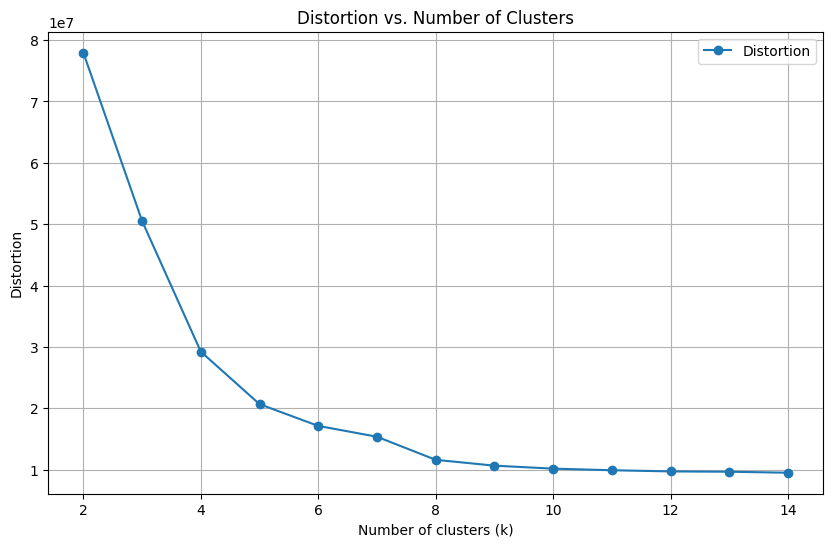

In [235]:
## TODO your code here ##





max_k = 20
distortions = test_cluster_size(X, max_k)

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k + 1), distortions, marker='o')
plt.title('Distortion vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.grid(True)
plt.legend(['Distortion'])
plt.show()



## TODO end ##

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


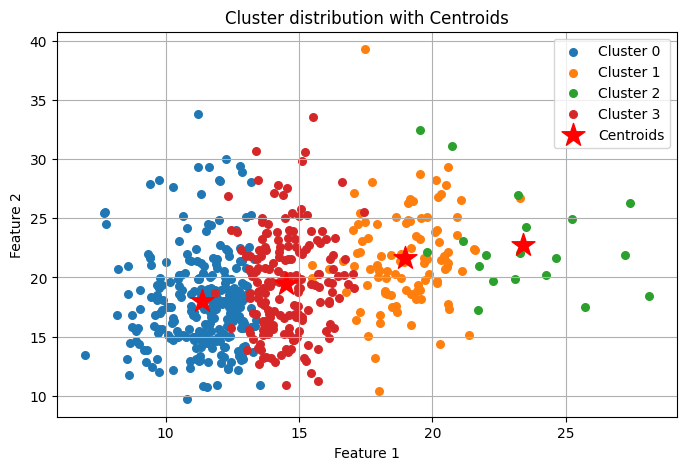

In [236]:
from sklearn.cluster import KMeans

def plot_clusters(X, clusters, centroids):
    plt.figure(figsize=(8, 5))

    for cluster_id in range(len(centroids)):

        cluster_points = X[clusters == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=30, label=f'Cluster {cluster_id}')

    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='*', label='Centroids')

    plt.title('Cluster distribution with Centroids')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

k = [4, 5, 6, 7, 8]
n_clusters = k[0]
kmeans = KMeans(n_clusters=n_clusters, max_iter=300)

kmeans.fit(X)

plot_clusters(X, kmeans.labels_, kmeans.cluster_centers_)




```
# This is formatted as code
```

## **3.5. [3 pts, manually graded] Plot distortion vs. k (with feature scaling)**

What we just did was running k-means clustering over the dataset X without any feature scaling. This time, we will rescale each feature to the standard range of (0,1) before passing it to k-means and computing the distortion.

Use `sklearn.preprocessing.MinMaxScaler` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) and scale the dataset X before passing it to the `test_cluster_size` function. As before, plot distortion vs. different k values and add it in the written report. Use max_k = 20. Determine the best k value from this plot and also mention it in the written report. Make sure your plot has axes labels, legend and title.

In [237]:
X = pd.DataFrame(data=cancer_dataset.data, columns=cancer_dataset.feature_names)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

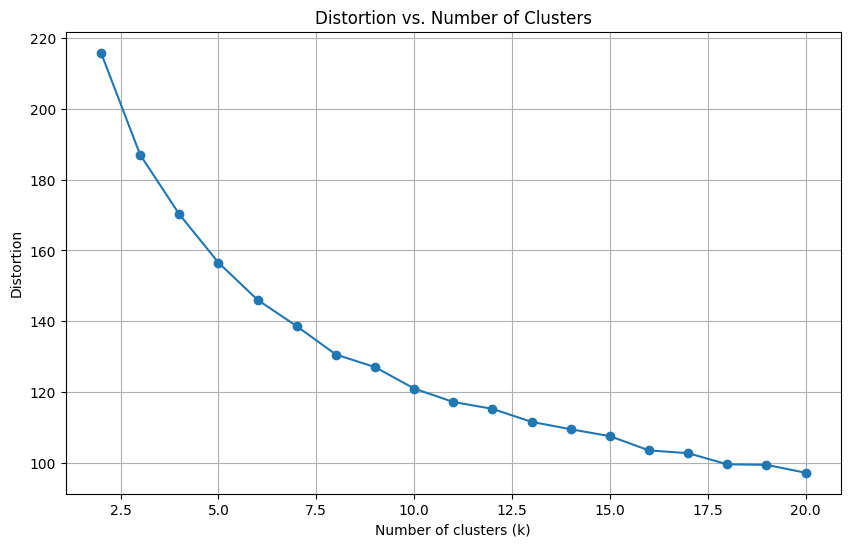

In [238]:
def test_cluster_size(X, max_k):
    distortions = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, max_iter=300)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    return distortions

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X)

max_k = 20
distortions = test_cluster_size(X_train_scaled, max_k)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k + 1), distortions, marker='o')
plt.title('Distortion vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.grid(True)
plt.show()


## **3.6. [4 pts, manually graded] Comments**

Answer these questions in the written report.

1. Why do you get different results with and without feature scaling?
2. Should you scale the features before fitting k-means? Why or why not?

# **4. [18 pts, 5 autograded, 13 manually graded] Principal Component Analysis**

## **4.1. [8 pts, manually graded] Exploring Effects of Different Princple Components in Linear Regression**
We have introduced you a way of dimension reduction, Principal Component Analysis, in class. Now, we would like to ask you to apply PCA from sklearn on the breast cancer dataset to observe its performance and interpret the major components.

In order to better compare the effects of PCA, we load the labels from the dataset.

Then, we will evaluate the performances of raw dataset and various numbers of pca components on LinearRegression classifier.

In the section, you are asked to draw a plot of test accuracies vs number of different principle components. The detailed instructions are included in the following cells.

Remember to **attach the plot** in your written submission, and also **make comments** about what you observe, explain the reason behind the trend, and what conclusion you could draw from the graph.

In [239]:
data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [240]:
# load the label from the dataset, which is a binary label 0/1 representing whether the cancer is benign or malignant

## TODO your code here ##
X = cancer_dataset.data
y = cancer_dataset.target

## TODO end ##

Accuracy with raw data: 0.9415


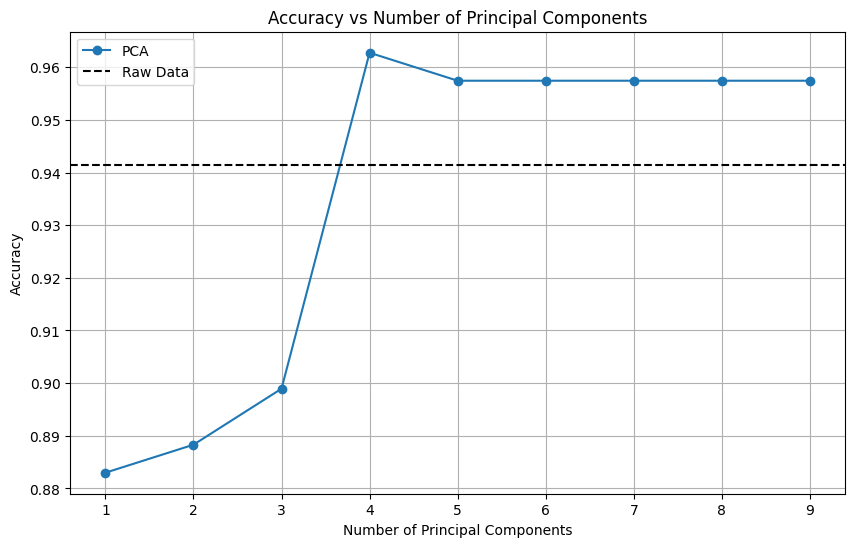

In [241]:
# try raw data vs PCA data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

## TODO your code here ##
# Step 1: split the data into train and test set by a test_size of 0.33.


# Step 2: Train a linear regression model using train set and predict on the test set.
# As the labels are binary, we should cast the predictions into binary labels as well. (Set predictions >=0.5 as 1)


# You might want to print out accuracy scores here



# Step 3: Iterate the number of components from 1 to 10 (exclusive).
# For each number of PCs, we are training a linear regression model and save its accuracy on the test set following the same style as above.
# Remeber to only fit the train set and not the test set.
# You might want to store your accuracies in a list


# Step 4: Make a plot to compare accuracy vs number of PCs on Linear Regression for the test set.
# Add a black, dashed line for the test accuracy of linear regression by feeding the raw input data.
# Remeber to add x, y labels and title to your plot, and comment on your observations.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
raw_accuracy = accuracy_score(y_test, y_pred_binary)

print(f"Accuracy with raw data: {raw_accuracy:.4f}")

pca_accuracies = []

for n_components in range(1, 10):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    y_pred_binary = (y_pred >= 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    pca_accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), pca_accuracies, marker='o', label='PCA')
plt.axhline(y=raw_accuracy, color='k', linestyle='--', label='Raw Data')
plt.title('Accuracy vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()




## TODO end ##

## **4.2. [5 pts] Understanding PCA**

### **4.2.1 [2 pts, autograded] Explained Ratio of PCA**
Given a threshold of explained ratio (0 < ratio < 1), compute the number of required PCs to reach the threshold.

In [242]:
def select_n_principal_components(data, variation):

  pca = PCA()
  pca.fit(data)

  cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

  n_components = np.where(cumulative_variance_ratio >= variation)[0][0] + 1

  return n_components

  ## TODO your code here ##

  ## TODO end ##

In [243]:
# PennGrader Grading Cell
student_ans = [select_n_principal_components(cancer_dataset['data'], 0.98), select_n_principal_components(cancer_dataset['data'], 0.99)]
grader.grade(test_case_id = 'test_select_n_principal_components', answer = student_ans)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **4.2.2 [3 pts, manually graded] Composition of PCA**
In this section, we ask you to understand which features specifically in the dataset contribute to the important PCs. We ask that you select the best number of principle components you got from previous part and analyze its composition (as there are multiple components contributing to each PC, you only need to specify the **top three** features that are explained by these PCs together).

In [244]:
## TODO your code here ##
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

cancer_dataset = load_breast_cancer()

pca = PCA(n_components=4)

pca.fit(cancer_dataset.data)

f_names = cancer_dataset.feature_names

top_features = select_n_principal_components(cancer_dataset['data'], 0.98
                                            )

print (top_features)

for i, component in enumerate(pca.components_):
    top_features = np.argsort(np.abs(component))[::-1][:3]
    print(f"PC {i+1}:")
    for feature_index in top_features:
        print(f" - {f_names[feature_index]} (value: {component[feature_index]:.3f})")
    print("\n")

## TODO end ##

1
PC 1:
 - worst area (value: 0.852)
 - mean area (value: 0.517)
 - area error (value: 0.056)


PC 2:
 - mean area (value: 0.852)
 - worst area (value: -0.520)
 - mean perimeter (value: 0.063)


PC 3:
 - area error (value: 0.990)
 - worst perimeter (value: -0.092)
 - mean perimeter (value: -0.072)


PC 4:
 - worst perimeter (value: -0.667)
 - worst texture (value: -0.542)
 - mean texture (value: -0.362)




## **4.3. [5 pts, manually graded] PCA and KMeans**
We first run PCA on the dataset for visualisation in 2D space. Note that k-means is actually being fit on the entire feature set.

Next, call your k-means class on the dataset X and obtain the clusters. Make sure to populate the "clusters" variable here. We have provided the plotting code for you.

**Add these plots in the written report.**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


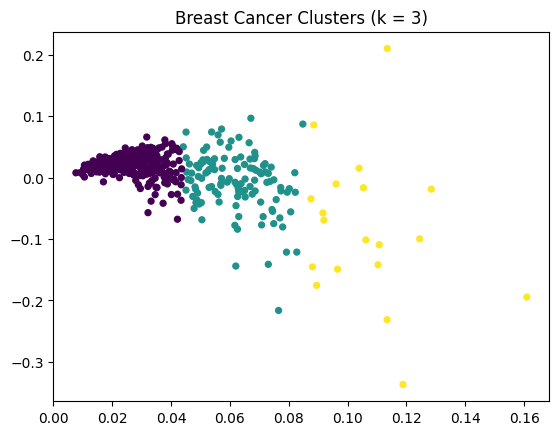

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


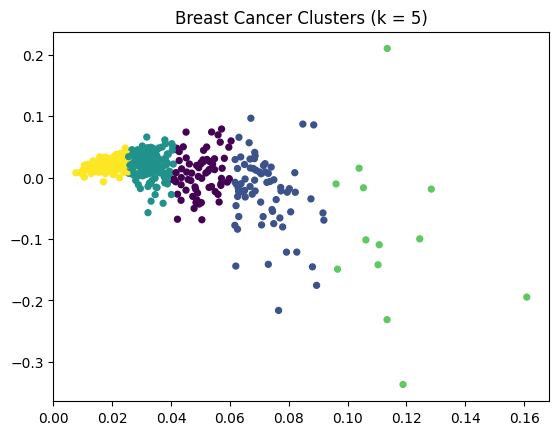

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


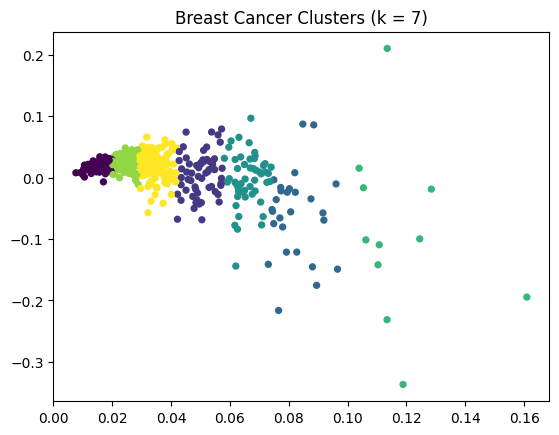

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


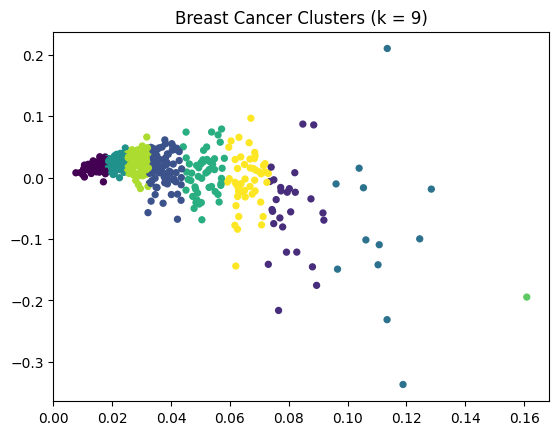

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


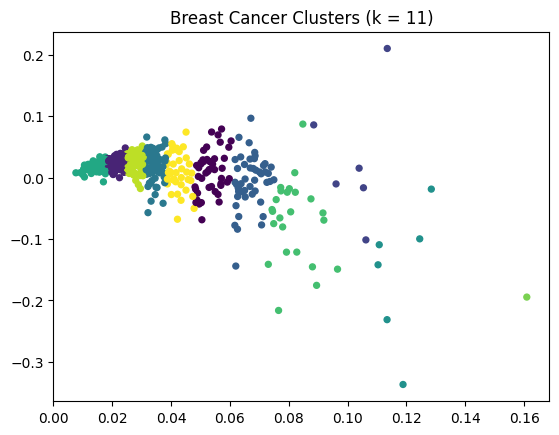

In [245]:
# PCA for visualisation in 2D.
pca = PCA(n_components = 2)
v = pca.fit(np.transpose(X)).components_

for k in [3,5,7,9, 11]:

    clusters = np.zeros(X.shape[0])

    ## TODO your code here ##
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X)
    ## TODO end ##

    plt.scatter(v[0], v[1], c=clusters, s=18)
    plt.title("Breast Cancer Clusters (k = "+str(k) + ")")
    plt.show()

## Submit to Gradescope
Congratulations! You've finished the homework. Don't forget to submit your final notebook on [Gradescope](gradescope.com).